In [59]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from pathlib import Path
import pandas as pd

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [60]:
pio.renderers.default = "iframe"

In [71]:
# base_path = "/data/saturation/random_runs_large_bungled"
# base_path = "/data/saturation/random_runs_large"
# base_path = "/data/saturation/r_stat_changes_messy"
# base_path = "/data/saturation/r_stat_changes"
# base_path = "/data/saturation/r_stat_changes_smaller_min"
# base_path = "/data/saturation/central_composite_design/ccd3"
base_path = "/data/saturation/central_composite_design/ccd4"
ivs = ["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]

In [72]:
stats_df = pd.read_csv(f"{base_path}/post_saturation_statistics_corners.csv")
# stats_df = pd.read_csv(f"{base_path}/post_saturation_statistics_interior.csv")
stats_df.head()

,areal_density_1_percentile,areal_density_2_percentile,areal_density_3_percentile,areal_density_4_percentile,areal_density_5_percentile,areal_density_6_percentile,areal_density_7_percentile,areal_density_8_percentile,areal_density_9_percentile,areal_density_10_percentile,...,min_rim_percentage,areal_density_index_90_percentile_max,areal_density_index_95_percentile_max,areal_density_index_97_percentile_max,areal_density_index_99_percentile_max,areal_density_index_995_percentile_max,path,n_craters_at_completion,n_craters_saturation,run_duration_seconds
0,0.214910,0.215802,0.216375,0.218411,0.226900,0.227179,0.227589,0.229509,0.229774,0.230107,...,0.303038,0.004056,0.004520,0.004520,0.004520,0.005006,/data/saturation/central_composite_design/ccd4...,500000,497232,2267.46
1,0.430176,0.433057,0.436613,0.439200,0.440679,0.442086,0.443254,0.444578,0.445701,0.446654,...,0.297486,0.086440,0.090926,0.094528,0.094930,0.098310,/data/saturation/central_composite_design/ccd4...,500000,235594,1248.05
2,0.581536,0.582109,0.583038,0.583200,0.583460,0.583594,0.583740,0.583886,0.583978,0.584127,...,0.498906,0.666908,0.670810,0.672269,0.699297,0.707623,/data/saturation/central_composite_design/ccd4...,596346,423577,5555.08
3,0.175753,0.183953,0.186645,0.196349,0.200808,0.202517,0.205036,0.207065,0.208939,0.210707,...,0.496452,0.103711,0.104020,0.105572,0.665635,0.665635,/data/saturation/central_composite_design/ccd4...,608913,522591,845.44
4,0.183548,0.191722,0.201123,0.210671,0.221206,0.226495,0.231780,0.235628,0.239513,0.245424,...,0.299489,0.010554,0.012424,0.012424,0.022340,0.098684,/data/saturation/central_composite_design/ccd4...,500000,469523,2365.33


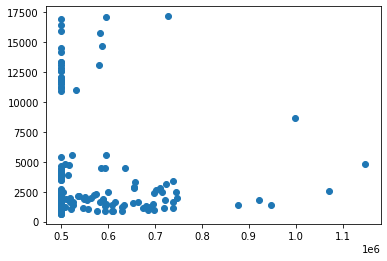

In [73]:
plt.scatter(stats_df.n_craters_at_completion, stats_df.run_duration_seconds)

### Visualizing 99th percentile post-saturation areal density

Notes on simulation parameters:
- Slope:
    - Controls the SFD of new craters. Larger slope -> more smaller craters
- R_stat multiplier:
    - Affects the minimum crater size for statistics collection: R_stat = R_stat multiplier * R_min
    - Range ~ 3-9
    - Affects how large a new crater must be to affect an existing crater. R_existing / R_new < R_stat multiplier
        - Larger R_stat multiplier -> more crater destruction
- Min rim percentage:
    - Controls how much of a crater's rim must be intact to remain in the record.
    - Larger min rim percentage -> more crater destruction
- Effective radius mutiplier:
    - Represents the effect of ejecta
    - Multiplies the radius of a new crater for the purposes of destroying existing craters' rims
    - Larger effective radius multiplier -> more crater destruction
    
Generally - the more crater destruction, the lower the areal density at saturation.



Questions for Dr. Kirchoff:
- Is it reasonable to fix the minimum crater size for statistics (R_stat), and allow R_min to vary instead?
- What are reasonable ranges for these four parameters?
- May we assume researchers can specify a reasonable range for all four of these parameters for a given terrain?



To do:
- Review Squyres' explanation of R_stat
- Normalize parameters' scales
- Indicators on plots for higher destruction direction?
- Look into effect sizes for linear models
- If we build models using Za, AD, etc, when do they match?
- Request a meeting with Dr. Kirchoff

In [75]:
metric = "areal_density_median"

In [76]:
# Normalize for coloring plot markers
stats_df["marker_size"] = 1
hover_data = {
    "slope": ":.3f",
    "effective_radius_multiplier": ":.3f",
    "r_stat_multiplier": ":.3f",
    "min_rim_percentage": ":.3f",
    metric : ":.3f"
}
fig = px.scatter_matrix(
    stats_df,
    dimensions=ivs,
    hover_data=hover_data,
    color=metric,
    size="marker_size",
    size_max=5,
    width=1200,
    height=800
)
fig.show()

In [77]:
# Destructive parameters
fig = px.scatter_3d(
    stats_df,
    x="min_rim_percentage",
    y="effective_radius_multiplier",
    z="r_stat_multiplier",
    color=metric,
    size="marker_size",
    size_max=10,
    hover_data=hover_data,
    width=1000,
    height=1000
)
fig.show()

In [218]:
fig = px.scatter_3d(
    stats_df,
    x="slope",
    y="effective_radius_multiplier",
    z="r_stat_multiplier",
    color=metric,
    size="marker_size",
    size_max=10,
    hover_data=hover_data,
    width=1000,
    height=1000
)
fig.show()

In [219]:
fig = px.scatter_3d(
    stats_df,
    x="slope",
    y="min_rim_percentage",
    z="r_stat_multiplier",
    color=metric,
    size="marker_size",
    size_max=10,
    hover_data=hover_data,
    width=1000,
    height=1000
)
fig.show()

In [220]:
fig = px.scatter_3d(
    stats_df,
    x="slope",
    y="effective_radius_multiplier",
    z="min_rim_percentage",
    color=metric,
    size="marker_size",
    size_max=10,
    hover_data=hover_data,
    width=1000,
    height=1000
)
fig.show()

### Linear regression model

In [50]:
def fit_and_report_model(model, data, dependent_variable, model_name):
    # X = data[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].copy()
    X = data.drop([dependent_variable], axis=1)
    y = data[dependent_variable]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    model_fit = model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    rmse = mean_squared_error(y_pred, y_train, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_train)
    print(f"{model_name}: Train RMSE: {rmse:.4f}, Train MAPE: {mape:.4f}")
    
    residuals = y_train - y_pred
    plt.hist(residuals)
    
    ks_norm_p = stats.kstest(residuals, cdf=stats.norm.cdf).pvalue
    ad_result = stats.anderson(residuals, dist="norm")
    print(f"KS test p-value on training residuals: {ks_norm_p:.3f}")
    print(f"AD test on training residuals: {ad_result.statistic:.3f}, critical values: {ad_result.critical_values}, significance levels: {ad_result.significance_level}")
    
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_pred, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_test)
    print(f"{model_name}: Test RMSE: {rmse:.4f}, Test MAPE: {mape:.4f}")
    
    y_pred_mean_model = [y_train.mean()] * len(y_test)
    rmse = mean_squared_error(y_pred_mean_model, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred_mean_model, y_test)
    print(f"Mean model: RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    
    return model_fit

#### Checking scatterplots

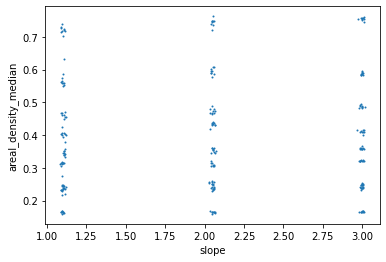

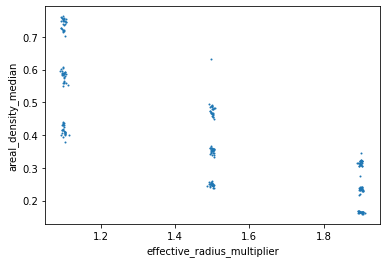

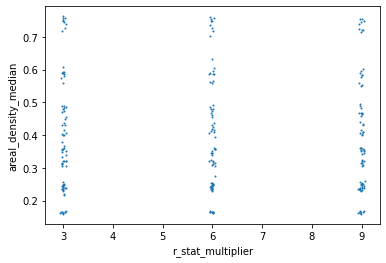

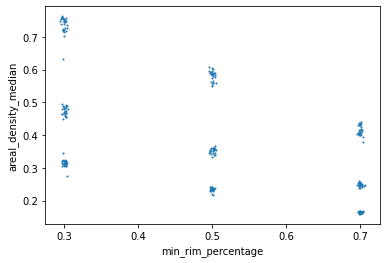

In [78]:
metric = "areal_density_median"
series = stats_df[metric]

for iv in ivs:
    plt.scatter(stats_df[iv], series, s=1)
    plt.xlabel(iv)
    plt.ylabel(metric)
    plt.show()

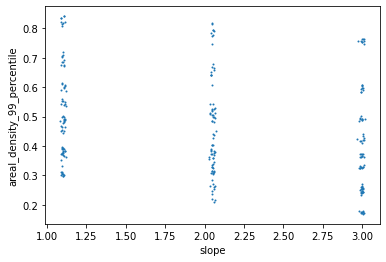

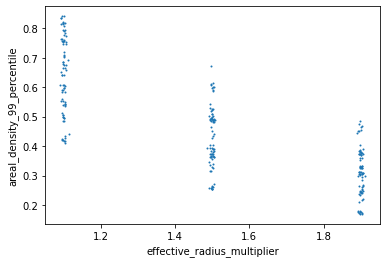

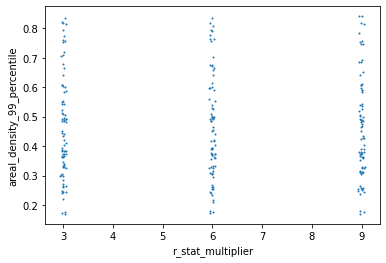

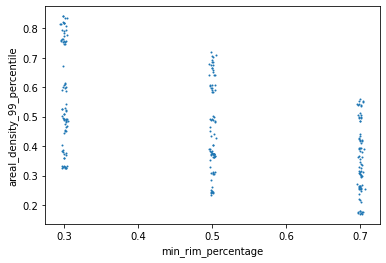

In [79]:
metric = "areal_density_99_percentile"
series = stats_df[metric]

for iv in ivs:
    plt.scatter(stats_df[iv], series, s=1)
    plt.xlabel(iv)
    plt.ylabel(metric)
    plt.show()

AD_max = f(slope, min_rim, eff_rad, r_stat_mult)
f(slope=1.8-2.0, min_rim=.4-.45, ....)
AD_max in (0.4, 0.6)

lm: Train RMSE: 0.0387, Train MAPE: 0.0877
KS test p-value on training residuals: 0.000
AD test on training residuals: 3.125, critical values: [0.565 0.643 0.772 0.9   1.071], significance levels: [15.  10.   5.   2.5  1. ]
lm: Test RMSE: 0.0422, Test MAPE: 0.1247
Mean model: RMSE: 0.1898, MAPE: 0.3549


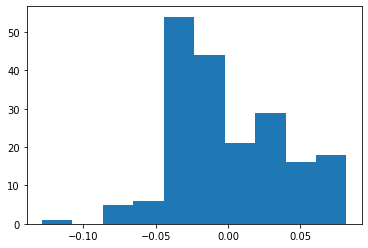

In [80]:
# Fit using sklearn
model = LinearRegression(fit_intercept=True)
model = fit_and_report_model(model, stats_df[ivs + [metric]], metric, "lm")

In [81]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2)
X = poly_transform.fit_transform(stats_df[ivs])
X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())
X[metric] = stats_df[metric]

lm: Train RMSE: 0.0186, Train MAPE: 0.0280
KS test p-value on training residuals: 0.000
AD test on training residuals: 4.671, critical values: [0.565 0.643 0.772 0.9   1.071], significance levels: [15.  10.   5.   2.5  1. ]
lm: Test RMSE: 0.0152, Test MAPE: 0.0308
Mean model: RMSE: 0.1898, MAPE: 0.3549


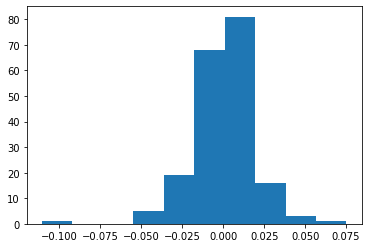

In [82]:
# Fit using sklearn
model = LinearRegression(fit_intercept=True)
model = fit_and_report_model(model, X, metric, "lm")

In [83]:
exclude = {
    metric,
    "r_stat_multiplier",
    "slope effective_radius_multiplier",
    "effective_radius_multiplier r_stat_multiplier",
    "slope r_stat_multiplier",
    "min_rim_percentage^2",
    "r_stat_multiplier min_rim_percentage",
    "r_stat_multiplier^2"
}
model = sm.OLS(stats_df[metric], sm.add_constant(X[[x for x in X.columns if x not in exclude]]))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     areal_density_99_percentile   R-squared:                       0.988
Model:                                     OLS   Adj. R-squared:                  0.988
Method:                          Least Squares   F-statistic:                     2832.
Date:                         Mon, 23 Jan 2023   Prob (F-statistic):          5.49e-223
Time:                                 18:38:23   Log-Likelihood:                 621.07
No. Observations:                          243   AIC:                            -1226.
Df Residuals:                              235   BIC:                            -1198.
Df Model:                                    7                                         
Covariance Type:                     nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
1                                                  2.4524      0.042     58.381      0.000       2.370       2.535
slope                                             -0.0590      0.013     -4.581      0.000      -0.084      -0.034
effective_radius_multiplier                       -1.5314      0.050    -30.555      0.000      -1.630      -1.433
min_rim_percentage                                -1.2243      0.040    -30.257      0.000      -1.304      -1.145
slope^2                                            0.0034      0.003      1.168      0.244      -0.002       0.009
slope min_rim_percentage                          -0.0300      0.010     -3.098      0.002      -0.049      -0.011
effective_radius_multiplier^2                      0.2903      0.016     17.890      0.000       0.258       0.322
effective_radius_multiplier min_rim_percentage     0.4916      0.023     21.401      0.000       0.446       0.537
==============================================================================
Omnibus:                       45.172   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.706
Skew:                          -0.588   Prob(JB):                     5.91e-50
Kurtosis:                       7.583   Cond. No.                         380.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

lm: Train RMSE: 0.0289, Train MAPE: 0.0575
KS test p-value on training residuals: 0.000
AD test on training residuals: 2.453, critical values: [0.565 0.643 0.772 0.9   1.071], significance levels: [15.  10.   5.   2.5  1. ]
lm: Test RMSE: 0.0282, Test MAPE: 0.0697
Mean model: RMSE: 0.1898, MAPE: 0.3549


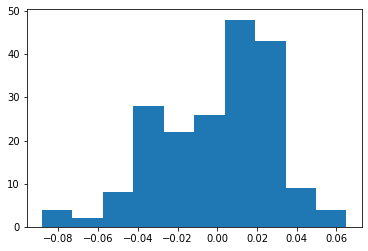

In [86]:
# Fit using sklearn
model = LinearRegression(fit_intercept=True)
model = fit_and_report_model(model, stats_df[[
    #"slope_effective_radius_multiplier",
                                                           "slope_r_stat_multiplier",
                                                           #"slope_min_rim_percentage",
                                                           #"r_stat_multiplier_effective_radius_multiplier", 
                                                           #"r_stat_multiplier_min_rim_percentage",
                                                           "effective_radius_multiplier_min_rim_percentage",
                                                           "slope_effective_radius_multiplier_min_rim_percentage",
                                                           "slope",
                                                           "effective_radius_multiplier",
                                                           "r_stat_multiplier",
                                                           "min_rim_percentage", metric]], metric, "lm")

In [87]:
# Fit using statsmodels for p-values
stats_df["slope_effective_radius_multiplier"] = stats_df.slope * stats_df.effective_radius_multiplier
stats_df["slope_r_stat_multiplier"] = stats_df.slope * stats_df.r_stat_multiplier
stats_df["slope_min_rim_percentage"] = stats_df.slope * stats_df.min_rim_percentage
stats_df["r_stat_multiplier_effective_radius_multiplier"] = stats_df.r_stat_multiplier * stats_df.effective_radius_multiplier
stats_df["r_stat_multiplier_min_rim_percentage"] = stats_df.r_stat_multiplier * stats_df.min_rim_percentage
stats_df["effective_radius_multiplier_min_rim_percentage"] = stats_df.min_rim_percentage * stats_df.effective_radius_multiplier
stats_df["slope_effective_radius_multiplier_min_rim_percentage"] = stats_df.slope * stats_df.min_rim_percentage * stats_df.effective_radius_multiplier
stats_df["slope_effective_radius_multiplier_squared"] = stats_df.effective_radius_multiplier * stats_df.effective_radius_multiplier

model = sm.OLS(stats_df[metric], sm.add_constant(stats_df[[
    #"slope_effective_radius_multiplier",
                                                           "slope_r_stat_multiplier",
                                                           "slope_effective_radius_multiplier_squared",
                                                           #"slope_min_rim_percentage",
                                                           #"r_stat_multiplier_effective_radius_multiplier", 
                                                           #"r_stat_multiplier_min_rim_percentage",
                                                           "effective_radius_multiplier_min_rim_percentage",
                                                           "slope_effective_radius_multiplier_min_rim_percentage",
                                                           "slope",
                                                           "effective_radius_multiplier",
                                                           "r_stat_multiplier",
                                                           "min_rim_percentage"]]))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     areal_density_99_percentile   R-squared:                       0.989
Model:                                     OLS   Adj. R-squared:                  0.988
Method:                          Least Squares   F-statistic:                     2583.
Date:                         Mon, 23 Jan 2023   Prob (F-statistic):          1.53e-223
Time:                                 18:38:40   Log-Likelihood:                 626.57
No. Observations:                          243   AIC:                            -1235.
Df Residuals:                              234   BIC:                            -1204.
Df Model:                                    8                                         
Covariance Type:                     nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    2.4390      0.040     60.405      0.000       2.359       2.519
slope_r_stat_multiplier                                  0.0001      0.001      0.171      0.865      -0.001       0.001
slope_effective_radius_multiplier_squared                0.2903      0.016     18.259      0.000       0.259       0.322
effective_radius_multiplier_min_rim_percentage           0.5401      0.025     21.721      0.000       0.491       0.589
slope_effective_radius_multiplier_min_rim_percentage    -0.0237      0.005     -4.582      0.000      -0.034      -0.014
slope                                                   -0.0430      0.006     -7.608      0.000      -0.054      -0.032
effective_radius_multiplier                             -1.5313      0.049    -31.186      0.000      -1.628      -1.435
r_stat_multiplier                                       -0.0008      0.001     -0.546      0.586      -0.003       0.002
min_rim_percentage                                      -1.2856      0.035    -37.226      0.000      -1.354      -1.218
==============================================================================
Omnibus:                       53.190   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.059
Skew:                          -0.688   Prob(JB):                     3.47e-67
Kurtosis:                       8.323   Cond. No.                         872.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
model = sm.OLS(stats_df[metric], sm.add_constant(stats_df[ivs]))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     areal_density_99_percentile   R-squared:                       0.949
Model:                                     OLS   Adj. R-squared:                  0.948
Method:                          Least Squares   F-statistic:                     1102.
Date:                         Mon, 23 Jan 2023   Prob (F-statistic):          2.93e-152
Time:                                 18:38:52   Log-Likelihood:                 441.87
No. Observations:                          243   AIC:                            -873.7
Df Residuals:                              238   BIC:                            -856.3
Df Model:                                    4                                         
Covariance Type:                     nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.4839      0.017     87.451      0.000       1.450       1.517
slope                          -0.0602      0.003    -18.308      0.000      -0.067      -0.054
effective_radius_multiplier    -0.4146      0.008    -53.209      0.000      -0.430      -0.399
r_stat_multiplier              -0.0006      0.001     -0.549      0.584      -0.003       0.001
min_rim_percentage             -0.5490      0.016    -35.209      0.000      -0.580      -0.518
==============================================================================
Omnibus:                        3.696   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                3.603
Skew:                           0.251   Prob(JB):                        0.165
Kurtosis:                       2.677   Cond. No.                         55.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
model = sm.OLS(stats_df[metric], sm.add_constant(stats_df[[
    # "slope_effective_radius_multiplier",
                                                           # "slope_r_stat_multiplier",
                                                           "slope_effective_radius_multiplier_squared",
                                                           # "slope_min_rim_percentage",
                                                           "r_stat_multiplier_effective_radius_multiplier", 
                                                           # "r_stat_multiplier_min_rim_percentage",
                                                           "effective_radius_multiplier_min_rim_percentage",
                                                           "slope_effective_radius_multiplier_min_rim_percentage",
                                                           "slope",
                                                           "effective_radius_multiplier",
                                                           "r_stat_multiplier",
                                                           "min_rim_percentage"]]))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     areal_density_99_percentile   R-squared:                       0.989
Model:                                     OLS   Adj. R-squared:                  0.989
Method:                          Least Squares   F-statistic:                     2610.
Date:                         Mon, 23 Jan 2023   Prob (F-statistic):          4.52e-224
Time:                                 18:39:04   Log-Likelihood:                 627.84
No. Observations:                          243   AIC:                            -1238.
Df Residuals:                              234   BIC:                            -1206.
Df Model:                                    8                                         
Covariance Type:                     nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    2.4589      0.042     59.036      0.000       2.377       2.541
slope_effective_radius_multiplier_squared                0.2903      0.016     18.355      0.000       0.259       0.322
r_stat_multiplier_effective_radius_multiplier            0.0024      0.001      1.576      0.116      -0.001       0.005
effective_radius_multiplier_min_rim_percentage           0.5402      0.025     21.837      0.000       0.491       0.589
slope_effective_radius_multiplier_min_rim_percentage    -0.0237      0.005     -4.607      0.000      -0.034      -0.014
slope                                                   -0.0424      0.004    -10.185      0.000      -0.051      -0.034
effective_radius_multiplier                             -1.5455      0.050    -31.117      0.000      -1.643      -1.448
r_stat_multiplier                                       -0.0041      0.002     -1.774      0.077      -0.009       0.000
min_rim_percentage                                      -1.2857      0.034    -37.421      0.000      -1.353      -1.218
==============================================================================
Omnibus:                       54.838   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              323.415
Skew:                          -0.709   Prob(JB):                     5.91e-71
Kurtosis:                       8.471   Cond. No.                         696.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [198]:
# Fit using statsmodels for p-values
stats_df["slope_effective_radius_multiplier"] = stats_df.slope * stats_df.effective_radius_multiplier
stats_df["slope_r_stat_multiplier"] = stats_df.slope * stats_df.r_stat_multiplier
stats_df["slope_min_rim_percentage"] = stats_df.slope * stats_df.min_rim_percentage
stats_df["r_stat_multiplier_effective_radius_multiplier"] = stats_df.r_stat_multiplier * stats_df.effective_radius_multiplier
stats_df["r_stat_multiplier_min_rim_percentage"] = stats_df.r_stat_multiplier * stats_df.min_rim_percentage
stats_df["effective_radius_multiplier_min_rim_percentage"] = stats_df.min_rim_percentage * stats_df.effective_radius_multiplier
stats_df["slope_effective_radius_multiplier_min_rim_percentage"] = stats_df.slope * stats_df.min_rim_percentage * stats_df.effective_radius_multiplier

model = sm.OLS(stats_df[metric], sm.add_constant(stats_df[[
    # "slope_effective_radius_multiplier",
                                                           "slope_r_stat_multiplier",
                                                           # "slope_min_rim_percentage",
                                                           # "r_stat_multiplier_effective_radius_multiplier", 
                                                           # "r_stat_multiplier_min_rim_percentage",
                                                           "effective_radius_multiplier_min_rim_percentage",
                                                           "slope_effective_radius_multiplier_min_rim_percentage",
                                                           "slope",
                                                           "effective_radius_multiplier",
                                                           "r_stat_multiplier",
                                                           "min_rim_percentage"]]))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     areal_density_99_percentile   R-squared:                       0.960
Model:                                     OLS   Adj. R-squared:                  0.958
Method:                          Least Squares   F-statistic:                     547.1
Date:                         Fri, 16 Dec 2022   Prob (F-statistic):          9.03e-108
Time:                                 17:34:13   Log-Likelihood:                 339.78
No. Observations:                          167   AIC:                            -663.6
Df Residuals:                              159   BIC:                            -638.6
Df Model:                                    7                                         
Covariance Type:                     nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    1.5685      0.045     34.743      0.000       1.479       1.658
slope_r_stat_multiplier                                 -0.0145      0.002     -8.410      0.000      -0.018      -0.011
effective_radius_multiplier_min_rim_percentage           0.3759      0.048      7.862      0.000       0.281       0.470
slope_effective_radius_multiplier_min_rim_percentage    -0.0439      0.014     -3.062      0.003      -0.072      -0.016
slope                                                    0.1097      0.016      6.662      0.000       0.077       0.142
effective_radius_multiplier                             -0.5171      0.023    -22.275      0.000      -0.563      -0.471
r_stat_multiplier                                        0.0058      0.003      2.151      0.033       0.000       0.011
min_rim_percentage                                      -1.0094      0.069    -14.531      0.000      -1.147      -0.872
==============================================================================
Omnibus:                       13.706   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.641
Skew:                          -0.594   Prob(JB):                     0.000401
Kurtosis:                       3.914   Cond. No.                         460.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Random forest model

RF(5, 5000): Train RMSE: 0.0165, Train MAPE: 0.0251
KS test p-value on training residuals: 0.000
AD test on training residuals: 4.782, critical values: [0.569 0.649 0.778 0.908 1.08 ], significance levels: [15.  10.   5.   2.5  1. ]
RF(5, 5000): Test RMSE: 0.0209, Test MAPE: 0.0338
Mean model: RMSE: 0.1689, MAPE: 0.2659


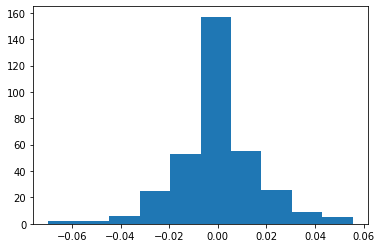

In [451]:
max_depth = 5
n_estimators = 5000

model = RandomForestRegressor(max_depth=max_depth,
                              n_estimators=n_estimators,
                              random_state=42)
model_fit = fit_and_report_model(model, stats_df, metric, f"RF({max_depth}, {n_estimators})")

### Gradient boosted trees model

GBT(3, 500): Train RMSE: 0.0028, Train MAPE: 0.0045
KS test p-value on training residuals: 0.000
AD test on training residuals: 1.278, critical values: [0.569 0.649 0.778 0.908 1.08 ], significance levels: [15.  10.   5.   2.5  1. ]
GBT(3, 500): Test RMSE: 0.0232, Test MAPE: 0.0394
Mean model: RMSE: 0.1689, MAPE: 0.2659


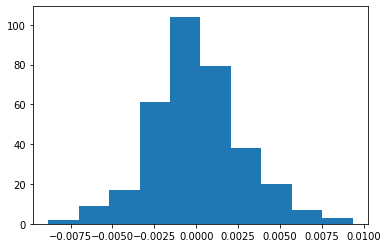

In [452]:
max_depth = 3
n_estimators = 500

model = GradientBoostingRegressor(max_depth=max_depth,
                                  n_estimators=n_estimators,
                                  random_state=42)
model_fit = fit_and_report_model(model, stats_df, metric, f"GBT({max_depth}, {n_estimators})")

### Plotting a single simulation's statistics

In [336]:
def read_stats_parquets(path: str) -> pd.DataFrame:
    # Read all statistics parquet files
    filenames = Path(path).glob("statistics*.parquet")
    dataframes = []
    for filename in filenames:
        df = pd.read_parquet(filename)
        dataframes.append(df)
    df = pd.concat(dataframes)
    df = df.sort_values(by=["crater_id"]).reset_index(drop=True)
    
    return df

def get_path(slope: float,
             effective_radius_multiplier: float,
             r_stat_multiplier: float,
             min_rim_percentage: float,
             base_path: str,
             prefix: str = "interior_point") -> pd.DataFrame:
    return f"{base_path}/{prefix}_{effective_radius_multiplier:.3f}_{min_rim_percentage:.3f}_{r_stat_multiplier:.3f}_{slope:.3f}/1/"


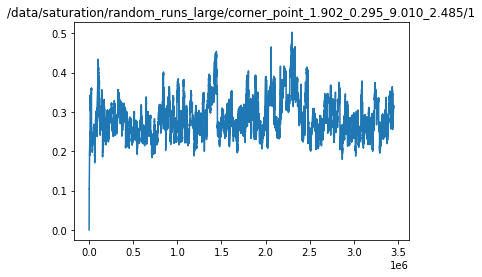

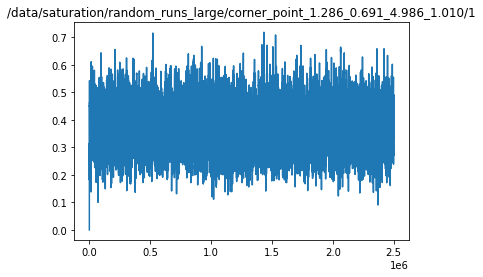

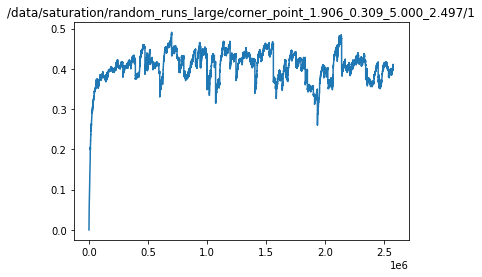

In [340]:
paths = list(Path(base_path).glob("corner*/1/"))

for path in paths[-3:]:
    df = read_stats_parquets(path)
    plt.plot(df.n_craters_added_in_study_region, df.areal_density)
    plt.title(path)
    plt.show()

In [342]:
# Finding saturation points
for path in paths[:]:
    df = read_stats_parquets(path)
    n_sims = df.shape[0]
    checkpoint = n_sims // 3 * 2
    checkpoint_max_ad = df.areal_density[:checkpoint].max()
    checkpoint_max_n = df.n_craters_in_study_region[:checkpoint].max()
    max_index = max(df.areal_density.idxmax(), df.n_craters_in_study_region.idxmax())
    print(f"{path}, {max_index / df.shape[0]:.3f}")
    # print(f"{path}, {max_index}, {df.shape[0]}, {checkpoint_max_ad:.3f}, {df.areal_density.max():.3f}, {checkpoint_max_n}, {df.n_craters_in_study_region.max()}")

/data/saturation/random_runs_large/corner_point_1.314_0.292_4.989_2.497/1, 0.516
/data/saturation/random_runs_large/corner_point_1.899_0.321_8.997_2.494/1, 0.431
/data/saturation/random_runs_large/corner_point_1.888_0.310_9.005_2.494/1, 0.155
/data/saturation/random_runs_large/corner_point_1.907_0.308_8.993_2.505/1, 0.667
/data/saturation/random_runs_large/corner_point_1.910_0.313_9.002_1.013/1, 0.667
/data/saturation/random_runs_large/corner_point_1.913_0.708_4.998_2.520/1, 0.503
/data/saturation/random_runs_large/corner_point_1.907_0.699_4.992_2.507/1, 0.253
/data/saturation/random_runs_large/corner_point_1.298_0.703_9.001_2.505/1, 0.647
/data/saturation/random_runs_large/corner_point_1.917_0.718_5.003_2.489/1, 0.667
/data/saturation/random_runs_large/corner_point_1.904_0.299_4.989_2.500/1, 0.667
/data/saturation/random_runs_large/corner_point_1.310_0.708_8.992_1.011/1, 0.338
/data/saturation/random_runs_large/corner_point_1.909_0.709_9.013_0.998/1, 0.351
/data/saturation/random_runs

In [271]:
all_ads = []
for path in paths:
    df = read_stats_parquets(path)
    max_index = df.areal_density.idxmax()
    df_sat = df.iloc[max_index:]
    print(f"{path}, {df_sat.areal_density.median()}, {df_sat.areal_density.std()}, {len(df_sat)}, {max_index}")
    # plt.hist(df_sat.areal_density)
    # plt.show()
    all_ads += list(df_sat.areal_density)

/data/saturation/random_runs_large/corner_point_1.279_0.696_5.007_2.516/1/, 0.37869560718536377, 0.04118308797478676, 1070801, 1429199
/data/saturation/random_runs_large/corner_point_1.279_0.720_5.008_2.504/1/, 0.38555464148521423, 0.053694453090429306, 268168, 3829583
/data/saturation/random_runs_large/corner_point_1.283_0.697_4.981_2.499/1/, 0.3523689806461334, 0.03518760949373245, 1678090, 821910
/data/saturation/random_runs_large/corner_point_1.315_0.703_4.988_2.500/1/, 0.376109778881073, 0.036757152527570724, 1611031, 888969
/data/saturation/random_runs_large/corner_point_1.323_0.708_4.999_2.510/1/, 0.34863096475601196, 0.05429280921816826, 7333923, 1047723
/data/saturation/random_runs_large/corner_point_1.278_0.306_9.013_2.516/1/, 0.5223565697669983, 0.04482534900307655, 2033493, 1227264
/data/saturation/random_runs_large/corner_point_1.282_0.296_4.987_2.503/1/, 0.7404835224151611, 0.029829982668161392, 2428292, 484981
/data/saturation/random_runs_large/corner_point_1.282_0.708_8

In [244]:
all_ads = []
for path in paths[:5]:
    df = read_stats_parquets(path)
    max_index = df.areal_density.idxmax()
    df_sat = df.iloc[-200000:]
    print(f"{df_sat.areal_density.median()}, {df_sat.areal_density.std()}")
    # plt.hist(df_sat.areal_density)
    # plt.show()
    all_ads += list(df_sat.areal_density)

0.3337796926498413, 0.0303382258862257
0.3838573098182678, 0.057279832661151886
0.3964063823223114, 0.04864026978611946
0.3873107433319092, 0.02527277171611786
0.3799813389778137, 0.041593410074710846


(array([ 11706.,  69224., 298511., 488837., 662387., 562797., 138384.,
        159897.,  65676.,  42581.]),
 array([0.25035217, 0.27706864, 0.30378511, 0.33050158, 0.35721804,
        0.38393451, 0.41065098, 0.43736745, 0.46408392, 0.49080038,
        0.51751685]),
 <BarContainer object of 10 artists>)

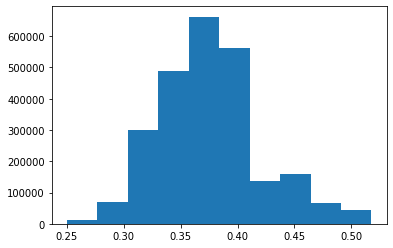

In [241]:
plt.hist(all_ads)

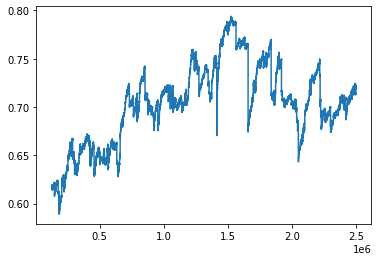

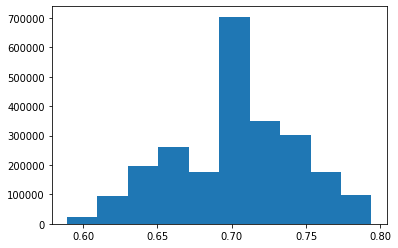

In [222]:
max_index = df.areal_density.idxmax()
df_sat = df.iloc[max_index:]
plt.plot(df_sat.n_craters_added_in_study_region, df_sat.areal_density)
plt.show()
plt.hist(df_sat.areal_density)
plt.show()

(array([17562., 39570., 13394., 80495., 33785.,   736., 32577., 16689.,
        19341., 14019.]),
 array([0.30460125, 0.3258928 , 0.34718436, 0.36847594, 0.3897675 ,
        0.41105905, 0.4323506 , 0.45364216, 0.47493374, 0.4962253 ,
        0.51751685], dtype=float32),
 <BarContainer object of 10 artists>)

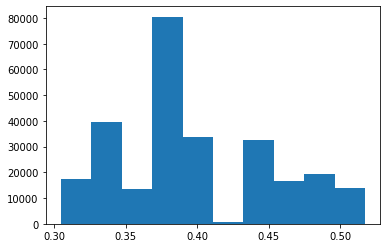

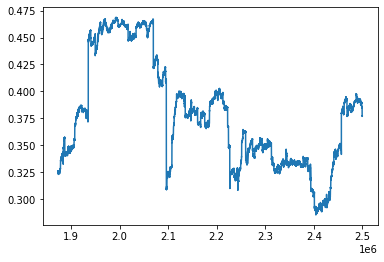